In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/AAIC/Jigsaw

/content/drive/My Drive/AAIC/Jigsaw


<h1><center>    Jigsaw unintended bias in Toxicity classification</center></h1>

# **1.Business problem**

## **1.1 Description**

Jigsaw which is formerly "Google ideas" is a technology incubator and is dedicated to understanding global challenges and applying technological solutions to them. It mainly focuses on Online Censorship , countering extremism, cyber attacks etc; It also does research on attacks on free speech and involved in providing remedy to it. As a part of this , Jigsaw created an API service for detecting toxic comments in 2018. But this service had showed some unintended bias against some groups realated to a religion , gender and color. The reason was the presence of comments on the above mentioned groups in the dataset. So ,in 2019 Jigsaw came up with new dataset, metric and the task given was to build a model that detect toxicity in the comments.

**Problem statement**


*   Identify which comments are toxic and measure the toxicity.  




## **1.2 Real world/Business Objectives and Constraints**



*   No latency requirements.
*   Interpretability is important.
*   Determining the probability of the comment to be toxic.



# 2.Machine Learning Probelm

## **2.1 Data**

### **2.1.1. Data Overview**



*   Source:https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data

*   There are two sets of data provided by Jigsaw , train and test. Train set contains comments ,toxicity and other identity columns related to the groups/communities/gender.






## **2.2 Mapping the real world problem to an ML problem**

### **2.2.1 Type of Machine Leaning Problem**


This problem can be posed as a binary classification problem with the categories being toxic and non-toxic.

### 2.2.2 Performance Metric



*   Jigsaw evaluates the models based on ROC-AUC and with other additional metric. So ,the performance metric should be ROC-AUC.

*   Confusion matrix



# 3.Exploratory Data Analysis

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

## 3.1 Reading data and basic stats

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [0]:
print(train.shape)

(1804874, 45)


In [0]:
print(test.shape)

(97320, 2)


In [0]:
train.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4


In [0]:
test.head(2)

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
id                                     int64
target                                 float64
comment_text                           object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float

In [0]:
train.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,publication_id,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.00000,1.804874e+06,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,0.001410,0.095268,0.127670,0.003237,0.001457,0.025611,0.001088,0.017863,0.006127,0.108687,0.049460,0.001220,0.000884,0.008248,0.006761,0.001494,0.001356,0.012083,0.006724,0.05695,4.986296e+01,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,2.445187e+06,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,0.030923,0.256671,0.305384,0.045801,0.030862,0.143739,0.016032,0.122145,0.058684,0.267894,0.202459,0.014102,0.011853,0.042717,0.037504,0.015374,0.017505,0.089183,0.069027,0.21596,2.769869e+01,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000e+00,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.100000e+01,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,5.400000e+01,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.769854e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,5.400000e+01,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1

In [0]:
#Checking whether there are any rows with null values
columns = train.columns
for column in columns:
  count = train[column].isnull().sum()
  print('The column -',column,'- has',count,'number of null values')

The column - id - has 0 number of null values
The column - target - has 0 number of null values
The column - comment_text - has 0 number of null values
The column - severe_toxicity - has 0 number of null values
The column - obscene - has 0 number of null values
The column - identity_attack - has 0 number of null values
The column - insult - has 0 number of null values
The column - threat - has 0 number of null values
The column - asian - has 1399744 number of null values
The column - atheist - has 1399744 number of null values
The column - bisexual - has 1399744 number of null values
The column - black - has 1399744 number of null values
The column - buddhist - has 1399744 number of null values
The column - christian - has 1399744 number of null values
The column - female - has 1399744 number of null values
The column - heterosexual - has 1399744 number of null values
The column - hindu - has 1399744 number of null values
The column - homosexual_gay_or_lesbian - has 1399744 number of n

Most of the columns are having Null values

Posing this problem as Classification problem by labeling the comments as toxic (Class label - 1) and non-toxic(Class label - 0)

In [0]:
from tqdm import tqdm
target = train['target']
label = []
for i in tqdm(target):
  if i < 0.5:
    temp = 0
  elif i>= 0.5:
    temp = 1
  label.append(temp)

100%|██████████| 1804874/1804874 [00:00<00:00, 1907415.39it/s]


In [0]:
label[0:10]

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]

In [0]:
train['target_label'] = label

In [0]:
train['target_label'].value_counts()

0    1660540
1     144334
Name: target_label, dtype: int64

Class label distribution

distribution of class labels


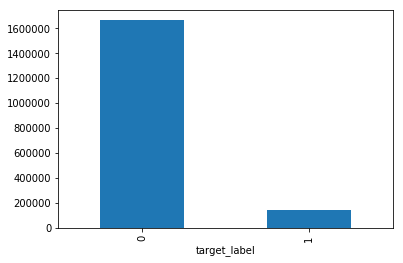

In [0]:
print('distribution of class labels')
train.groupby('target_label')['id'].count().plot.bar()

In [0]:
print('Percentage of non-toxic comments in the data',(train['target_label'].value_counts()[0]/(train['target_label'].value_counts()[0]+train['target_label'].value_counts()[1])*100))
print('Percentage of toxic comments in the data',(train['target_label'].value_counts()[1]/(train['target_label'].value_counts()[0]+train['target_label'].value_counts()[1])*100))

Percentage of non-toxic comments in the data 92.00309827722046
Percentage of toxic comments in the data 7.99690172277954


The dataset is highly imbalanced with the ration nearly 92:8.

## **3.2 New Features**

### 3.2.1 Comment Length

In [0]:
train['comment_len'] = train['comment_text'].str.len()
test['comment_len'] = test['comment_text'].str.len()

In [0]:
train['comment_len'][0:10]

0    101
1    114
2     86
3     84
4     36
5     20
6     27
7     19
8    120
9     80
Name: comment_len, dtype: int64

### 3.2.2 Numberof words in the comment

In [0]:
train['comment_n_words'] = train['comment_text'].apply(lambda row: len(row.split(" ")))
test['comment_n_words'] = test['comment_text'].apply(lambda row: len(row.split(" ")))

# 4.Text Features

## 4.1 Text Preprocessing


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)  
    porter = PorterStemmer()
    pattern = re.compile('\W')    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)   
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()    
    return x
    

Removing unnecessary punctuations , stopwords etc, from the text data

In [0]:
comment_train = train['comment_text']
comment_test = test['comment_text']
comment_train_text = []
comment_test_text = []
for com in tqdm(comment_train.values):
  temp = preprocess(com)
  comment_train_text.append(temp.lower().strip())

for com in tqdm(comment_test.values):
  temp = preprocess(com)
  comment_test_text.append(temp.lower().strip())

100%|██████████| 97320/97320 [00:43<00:00, 2250.23it/s]


In [0]:
train['comment_text_pre'] = comment_train_text
test['comment_text_pre'] = comment_test_text

## 4.2 New features using Sentiment Analyser

In [0]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [0]:
Compound_value_train = []
Positive_value_train = []
Negative_value_train = []
Neutral_value_train = []
for i in tqdm(train['comment_text_pre']):
  temp = sid.polarity_scores(i)
  Compound_value_train.append(temp['compound'])
  Positive_value_train.append(temp['pos'])
  Negative_value_train.append(temp['neg'])
  Neutral_value_train.append(temp['neu'])

100%|██████████| 1804874/1804874 [18:53<00:00, 1592.01it/s]


In [0]:
Compound_value_test = []
Positive_value_test = []
Negative_value_test = []
Neutral_value_test = []
for i in tqdm(test['comment_text_pre']):
  temp = sid.polarity_scores(i)
  Compound_value_test.append(temp['compound'])
  Positive_value_test.append(temp['pos'])
  Negative_value_test.append(temp['neg'])
  Neutral_value_test.append(temp['neu'])

100%|██████████| 97320/97320 [01:01<00:00, 1584.57it/s]


In [0]:
train['Compound'] = Compound_value_train
train['Positive'] = Positive_value_train
train['Negative'] = Negative_value_train 
train['Neutral'] = Neutral_value_train 

test['Compound'] = Compound_value_test
test['Positive'] = Positive_value_test 
test['Negative'] = Negative_value_test 
test['Neutral'] = Neutral_value_test 

# 5.Exploratory Data Analysis (EDA)

## 5.1 Comment_len

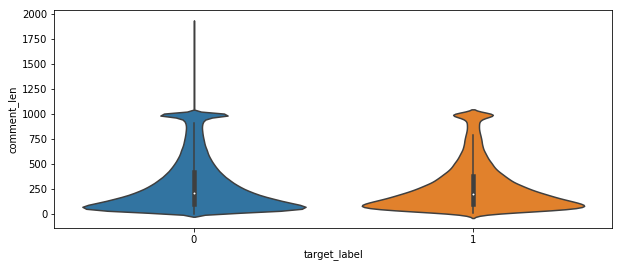

In [0]:
plt.figure(figsize=(10,4))
sns.violinplot(x = 'target_label', y = 'comment_len', data = train)

The plot states the length of the comments doesnt show much impact on toxicity of the comment. But , there is still some minute difference present in the plots.

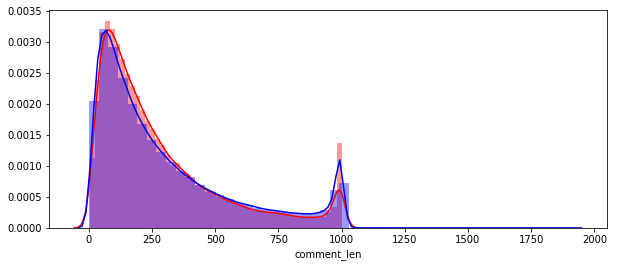

In [0]:
plt.figure(figsize=(10, 4))
sns.distplot(train[train['target_label'] == 1.0]['comment_len'][0:] , label = "1", color= 'red')
sns.distplot(train[train['target_label'] == 0.0]['comment_len'][0:] , label = "0" , color = 'blue' )
plt.show()

The plot says that there are cases where toxicity is slightly dependent on lenght of the comment . Hence this feature can be slightly important in modelling

## 5.2 Comment_n_words

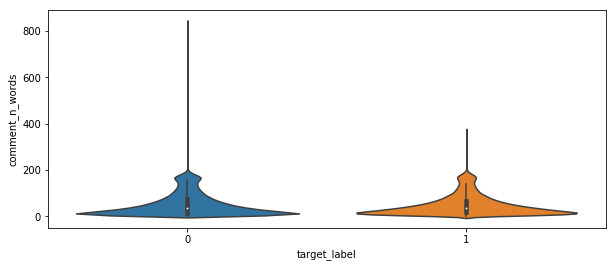

In [0]:
plt.figure(figsize=(10,4))
sns.violinplot(x = 'target_label', y = 'comment_n_words', data = train)

Althought the plots are almost same , there is slight difference.

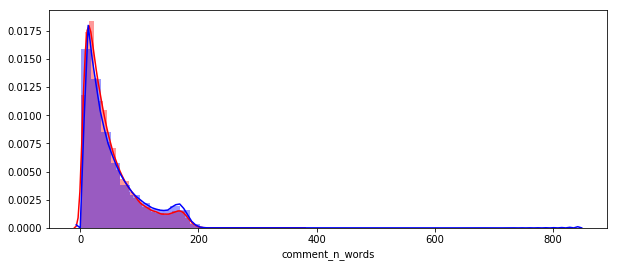

In [0]:
plt.figure(figsize=(10, 4))
sns.distplot(train[train['target_label'] == 1.0]['comment_n_words'][0:] , label = "1", color= 'red')
sns.distplot(train[train['target_label'] == 0.0]['comment_n_words'][0:] , label = "0" , color = 'blue' )
plt.show()

The pdf are not almost same. There is slight difference. So this feature may be helpful in modelling.

## 5.3 Compound

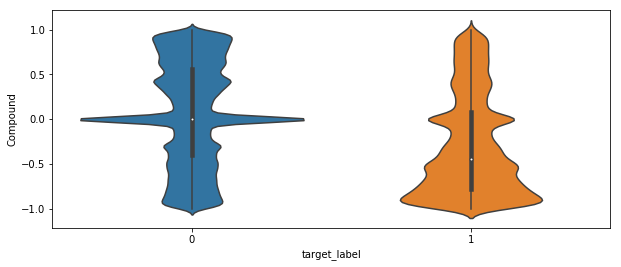

In [0]:
plt.figure(figsize=(10,4))
sns.violinplot(x = 'target_label', y = 'Compound', data = train)

The plots are different to some extent.

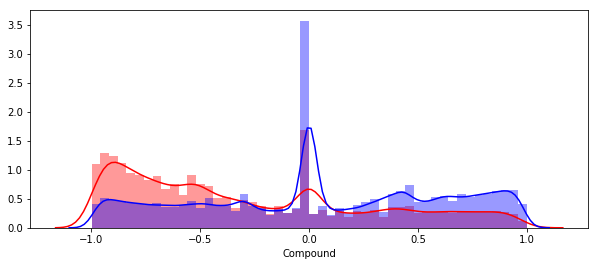

In [0]:
plt.figure(figsize=(10, 4))
sns.distplot(train[train['target_label'] == 1.0]['Compound'][0:] , label = "1", color= 'red')
sns.distplot(train[train['target_label'] == 0.0]['Compound'][0:] , label = "0" , color = 'blue' )
plt.show()

The plot shown that there are cases where the value of compound has differentiated the two classes. This feature is really helpful.

## 5.4 Positive

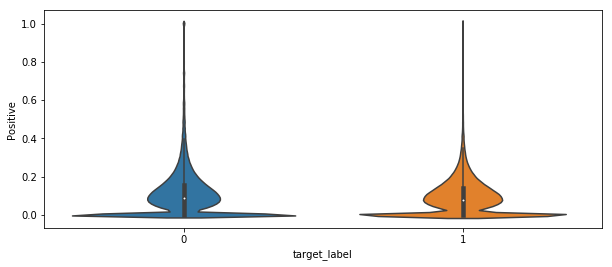

In [0]:
plt.figure(figsize=(10,4))
sns.violinplot(x = 'target_label', y = 'Positive', data = train)

The plots are almost same.

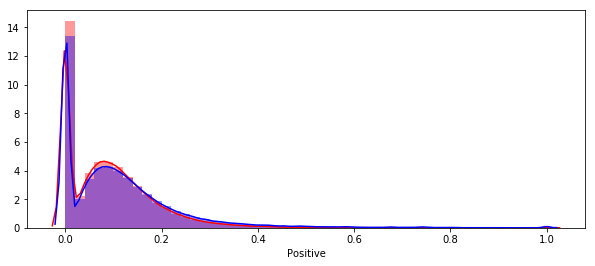

In [0]:
plt.figure(figsize=(10, 4))
sns.distplot(train[train['target_label'] == 1.0]['Positive'][0:] , label = "1", color= 'red')
sns.distplot(train[train['target_label'] == 0.0]['Positive'][0:] , label = "0" , color = 'blue' )
plt.show()

Clealry the pdfs are almost overlapping with each other . But there is still a little difference.

## 5.5 Negative

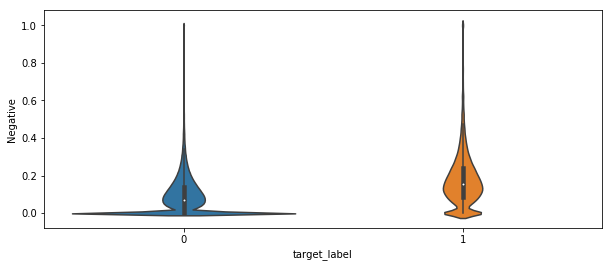

In [0]:
plt.figure(figsize=(10,4))
sns.violinplot(x = 'target_label', y = 'Negative', data = train)

The plot shows that more comments with 0 negative value are non-toxic.

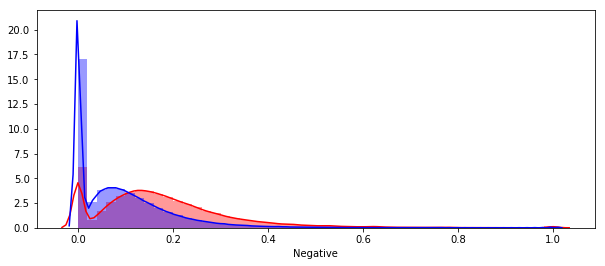

In [0]:
plt.figure(figsize=(10, 4))
sns.distplot(train[train['target_label'] == 1.0]['Negative'][0:] , label = "1", color= 'red')
sns.distplot(train[train['target_label'] == 0.0]['Negative'][0:] , label = "0" , color = 'blue' )
plt.show()

The more the negative value , the comment is more likely to be toxic.

## 5.6 Neutral

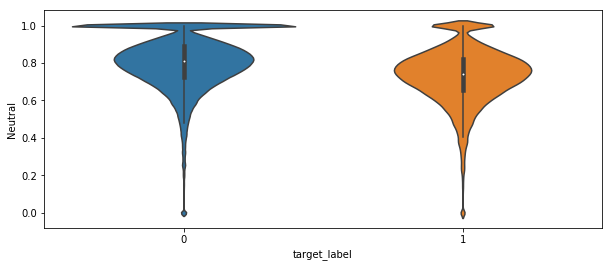

In [0]:
plt.figure(figsize=(10,4))
sns.violinplot(x = 'target_label', y = 'Neutral', data = train)

There are more number of non-toxic comments with Neutral value as 1 than Toxic ones.

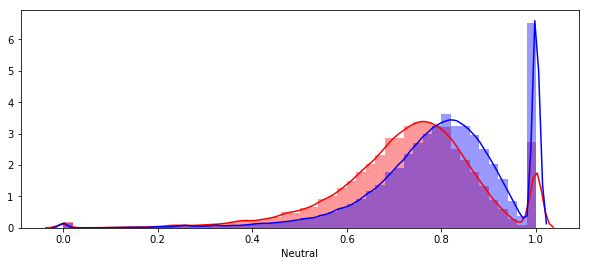

In [0]:
plt.figure(figsize=(10, 4))
sns.distplot(train[train['target_label'] == 1.0]['Neutral'][0:] , label = "1", color= 'red')
sns.distplot(train[train['target_label'] == 0.0]['Neutral'][0:] , label = "0" , color = 'blue' )
plt.show()

Comments with neutral value of more than 0.8 are more likely to be non-toxic.

In [0]:
train.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count', 'target_label',
       'comment_len', 'comment_n_words', 'comment_text_pre', 'Compound',
       'Positive', 'Negative', 'Neutral'],
      dtype='object')

Removing unnecessary features

In [0]:
train.drop(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'], axis=1, inplace= True)

In [0]:
label = train['target_label']
train.drop(['target_label'], axis=1, inplace= True)

In [0]:
train.columns

Index(['comment_len', 'comment_n_words', 'comment_text_pre', 'Compound',
       'Positive', 'Negative', 'Neutral'],
      dtype='object')

In [0]:
test.drop(['id'], axis=1, inplace= True)

In [0]:
test.drop(['comment_text'], axis=1, inplace= True)

In [0]:
test.columns

Index(['comment_len', 'comment_n_words', 'comment_text_pre', 'Compound',
       'Positive', 'Negative', 'Neutral'],
      dtype='object')

# 6.Splitting ( Stratified split (80:20))

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_CV, y_train, y_CV = train_test_split(train, label, test_size=0.20, random_state=0 , stratify = label)

In [0]:
print("Shape of X_train:",X_train.shape,"--- Shape of y_train:",y_train.shape)
print("Shape of X_CV:",X_CV.shape,"--- Shape of y_cv:",y_CV.shape)

Shape of X_train: (1443899, 7) --- Shape of y_train: (1443899,)
Shape of X_CV: (360975, 7) --- Shape of y_cv: (360975,)


# 7.Vectorisation of text data (Tfidf Vectorisation)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
text_vec = TfidfVectorizer()
text_vec.fit(X_train['comment_text_pre'])

text_tfidf_train = text_vec.transform(X_train['comment_text_pre'])
text_tfidf_cv = text_vec.transform(X_CV['comment_text_pre'])
text_tfidf_test = text_vec.transform(test['comment_text_pre'])
# getting all the feature names (words)
text_feature_names = text_vec.get_feature_names()

In [0]:
X_train.drop(['comment_text_pre'], axis=1, inplace= True)
X_CV.drop(['comment_text_pre'], axis=1, inplace= True)
test.drop(['comment_text_pre'], axis=1, inplace= True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [0]:
from sklearn.preprocessing import Normalizer
n = Normalizer()
n.fit(X_train)
X_train_n = n.transform(X_train)
X_test_n = n.transform(test)
X_CV_n = n.transform(X_CV)

In [0]:
from sklearn.preprocessing import MinMaxScaler
m = MinMaxScaler()
m.fit(X_train)
X_train_m = m.transform(X_train)
X_test_m = m.transform(test)
X_CV_m = m.transform(X_CV)

In [0]:
from scipy.sparse import hstack
S1_train = hstack((X_train_n,text_tfidf_train))
S1_test = hstack((X_test_n,text_tfidf_test))
S1_CV =hstack((X_CV_n,text_tfidf_cv))

In [0]:
from scipy.sparse import hstack
S1_train_NB = hstack((X_train_m,text_tfidf_train))
S1_test_NB = hstack((X_test_m,text_tfidf_test))
S1_CV_NB =hstack((X_CV_m,text_tfidf_cv))

# 8.Modelling

## 8.1 Naive Bayes

### 8.1.1 Hyperparameter tuning

100%|██████████| 16/16 [01:07<00:00,  4.24s/it]


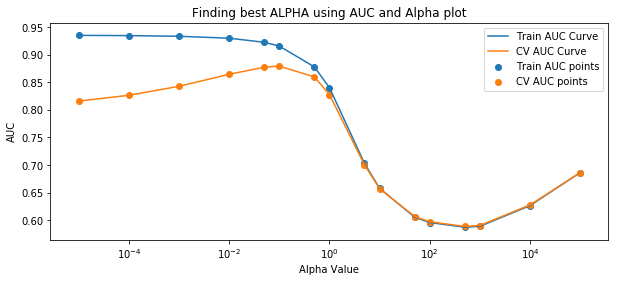

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
train_auc= []
cv_auc= []
alpha_value = [0.00001,0.0001,0.001,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,10000,100000]
for i in tqdm(alpha_value):
    model=MultinomialNB(alpha = i)
    model.fit(S1_train_NB, y_train)
    y_train_pred=model.predict_proba(S1_train_NB)[:,1]
    y_cv_pred=model.predict_proba(S1_CV_NB)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_CV, y_cv_pred))
plt.figure(figsize=(10,4))
plt.axes(xscale='log')
plt.plot(alpha_value, train_auc, label='Train AUC Curve')
plt.plot(alpha_value, cv_auc, label='CV AUC Curve')
plt.scatter(alpha_value, train_auc, label='Train AUC points')
plt.scatter(alpha_value, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("Alpha Value")
plt.ylabel("AUC")
plt.title("Finding best ALPHA using AUC and Alpha plot")
plt.show()

### 8.1.2 Building best model

In [0]:
model=MultinomialNB(alpha = 0.1)
model.fit(S1_train_NB, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [0]:
y_train_pred = model.predict_proba(S1_train_NB)[:,1]
y_cv_pred = model.predict_proba(S1_CV_NB)[:,1]

In [0]:
def find_best_threshold(threshould, fpr, tpr):
  t = threshould[np.argmax(tpr*(1-fpr))] # (tpr*(1-fpr)) will be maximum if your fpr isvery low and tpr is very high
  print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
  return t
def predict_with_best_t(proba, threshould):
  predictions = []
  for i in proba:
    if i>=threshould:
      predictions.append(1)
    else:
      predictions.append(0)
  return predictions

### 8.1.3 ROC curve

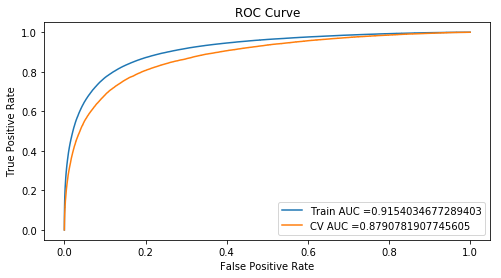

In [0]:
from sklearn.metrics import roc_curve, auc
train_fpr,train_tpr,train_thresholds = roc_curve(y_train, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_CV,y_cv_pred)
train_auc =auc(train_fpr, train_tpr)
cv_auc = auc(cv_fpr, cv_tpr)
plt.figure(figsize=(8,4))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(cv_auc))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

### 8.1.4 Confusion matrix

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("CV confusion matrix")
print(confusion_matrix(y_CV, predict_with_best_t(y_cv_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.7077761475987623 for threshold 0.089
Train confusion matrix
[[1137470  190962]
 [  20022   95445]]
CV confusion matrix
[[283536  48572]
 [  7089  21778]]


**Train**

Text(0.5, -1.5, 'Predicted')

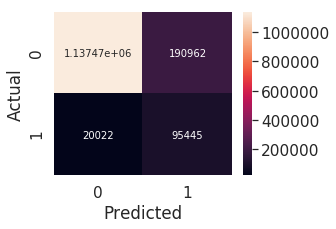

In [0]:
conf_matr_train = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), range(2),range(2))
conf_matr_cv = pd.DataFrame(confusion_matrix(y_CV, predict_with_best_t(y_cv_pred,best_t)), range(2),range(2))
plt.figure(figsize = (4,3))
sns.set(font_scale=1.4) #for label size
sns.heatmap(conf_matr_train, annot= True,annot_kws={"size": 10}, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

**CV**

Text(0.5, -1.5, 'Predicted')

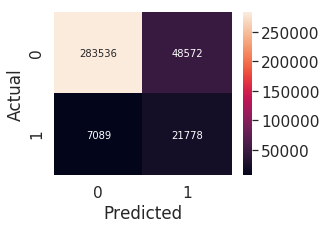

In [0]:
plt.figure(figsize = (4,3))
sns.set(font_scale=1.4) #for label size
sns.heatmap(conf_matr_cv, annot= True,annot_kws={"size": 10}, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## 8.2 Linear SVM 

### 8.2.1 Hyperparameters tuning

100%|██████████| 17/17 [03:33<00:00, 12.44s/it]


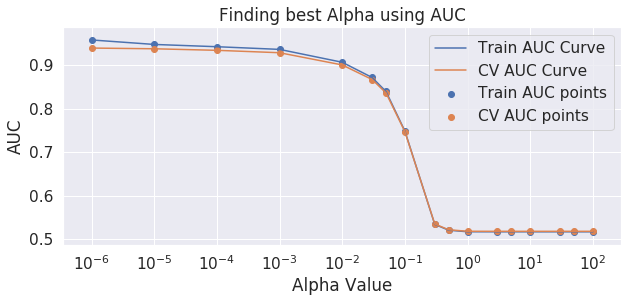

In [0]:
from sklearn.linear_model import SGDClassifier
train_auc= []
cv_auc= []
alpha_value = [0.000001,0.00001,0.0001,0.001,0.01,0.03,0.05,0.1,0.3,0.5,1,3,5,10,30,50,100]
for i in tqdm(alpha_value):
    model=SGDClassifier(loss = 'hinge',alpha =i)
    model.fit(S1_train, y_train)
    y_train_pred=model.decision_function(S1_train)
    y_cv_pred=model.decision_function(S1_CV)
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_CV, y_cv_pred))
plt.figure(figsize=(10,4))
plt.axes(xscale='log')
plt.plot(alpha_value, train_auc, label='Train AUC Curve')
plt.plot(alpha_value, cv_auc, label='CV AUC Curve')
plt.scatter(alpha_value, train_auc, label='Train AUC points')
plt.scatter(alpha_value, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("Alpha Value")
plt.ylabel("AUC")
plt.title("Finding best Alpha using AUC")
plt.show()

### 8.2.2 Building best model

In [0]:
model=SGDClassifier(loss = 'hinge',alpha =0.000001)
model.fit(S1_train, y_train)

SGDClassifier(alpha=1e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
y_train_pred = model.decision_function(S1_train)
y_cv_pred = model.decision_function(S1_CV)

### 8.2.3 ROC curve

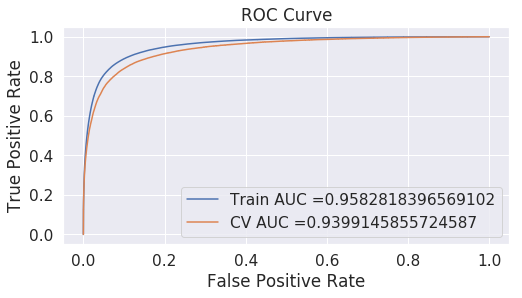

In [0]:
train_fpr,train_tpr,train_thresholds = roc_curve(y_train, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_CV,y_cv_pred)
train_auc =auc(train_fpr, train_tpr)
cv_auc = auc(cv_fpr, cv_tpr)
plt.figure(figsize=(8,4))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(cv_auc))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

### 8.2.4 Confusion Matrix

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("CV confusion matrix")
print(confusion_matrix(y_CV, predict_with_best_t(y_cv_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.7995531433574763 for threshold -1.336
Train confusion matrix
[[1196557  131875]
 [  12970  102497]]
CV confusion matrix
[[297616  34492]
 [  4524  24343]]


**Train Confusion Matrix**

Text(0.5, -1.5, 'Predicted')

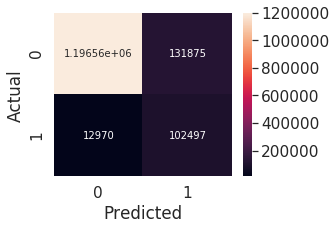

In [0]:
conf_matr_train = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), range(2),range(2))
conf_matr_cv = pd.DataFrame(confusion_matrix(y_CV, predict_with_best_t(y_cv_pred,best_t)), range(2),range(2))
plt.figure(figsize = (4,3))
sns.set(font_scale=1.4) #for label size
sns.heatmap(conf_matr_train, annot= True,annot_kws={"size": 10}, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

**CV Confusion Matrix**

Text(0.5, -1.5, 'Predicted')

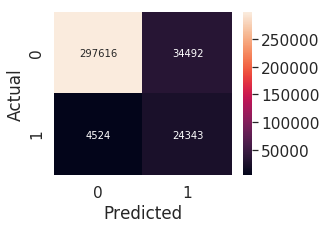

In [0]:
plt.figure(figsize = (4,3))
sns.set(font_scale=1.4) #for label size
sns.heatmap(conf_matr_cv, annot= True,annot_kws={"size": 10}, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## 8.3 Logistic Regression (Class weight Balanced)

### 8.3.1 Hyperparameter tuning


100%|██████████| 17/17 [03:58<00:00, 13.12s/it]


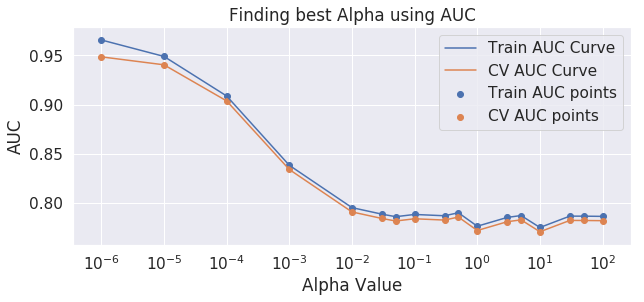

In [0]:
from sklearn.linear_model import SGDClassifier
train_auc= []
cv_auc= []
alpha_value = [0.000001,0.00001,0.0001,0.001,0.01,0.03,0.05,0.1,0.3,0.5,1,3,5,10,30,50,100]
for i in tqdm(alpha_value):
    model=SGDClassifier(class_weight='balanced',loss = 'log',alpha =i)
    model.fit(S1_train, y_train)
    y_train_pred=model.predict_proba(S1_train)[:,1]
    y_cv_pred=model.predict_proba(S1_CV)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_CV, y_cv_pred))
plt.figure(figsize=(10,4))
plt.axes(xscale='log')
plt.plot(alpha_value, train_auc, label='Train AUC Curve')
plt.plot(alpha_value, cv_auc, label='CV AUC Curve')
plt.scatter(alpha_value, train_auc, label='Train AUC points')
plt.scatter(alpha_value, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("Alpha Value")
plt.ylabel("AUC")
plt.title("Finding best Alpha using AUC")
plt.show()

### 8.3.2 Building best model


In [0]:
from sklearn.linear_model import SGDClassifier
model=SGDClassifier(class_weight='balanced',loss = 'log',alpha =0.000001)
model.fit(S1_train, y_train)

SGDClassifier(alpha=1e-06, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
y_train_pred = model.predict_proba(S1_train)[:,1]
y_cv_pred = model.predict_proba(S1_CV)[:,1]

### 8.3.3 ROC curve

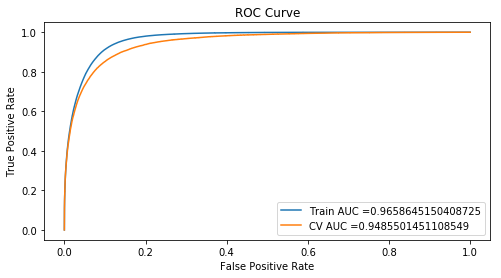

In [0]:
from sklearn.metrics import roc_curve, auc
train_fpr,train_tpr,train_thresholds = roc_curve(y_train, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_CV,y_cv_pred)
train_auc =auc(train_fpr, train_tpr)
cv_auc = auc(cv_fpr, cv_tpr)
plt.figure(figsize=(8,4))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(cv_auc))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

### 8.3.4 Confusion Matrix


In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("CV confusion matrix")
print(confusion_matrix(y_CV, predict_with_best_t(y_cv_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8249711498980763 for threshold 0.441
Train confusion matrix
[[1173340  155092]
 [   7619  107848]]
CV confusion matrix
[[292221  39887]
 [  3519  25348]]


**Train Confusion Matrix**

Text(0.5, -1.5, 'Predicted')

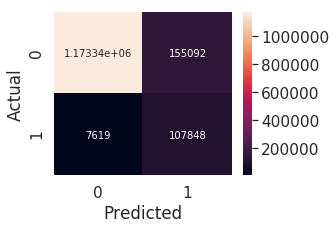

In [0]:
conf_matr_train = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), range(2),range(2))
conf_matr_cv = pd.DataFrame(confusion_matrix(y_CV, predict_with_best_t(y_cv_pred,best_t)), range(2),range(2))
plt.figure(figsize = (4,3))
sns.set(font_scale=1.4) #for label size
sns.heatmap(conf_matr_train, annot= True,annot_kws={"size": 10}, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

**CV Confusion Matrix**

Text(0.5, -1.5, 'Predicted')

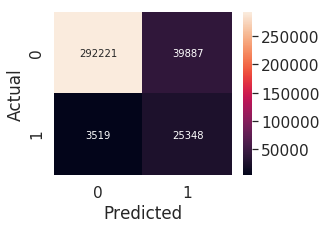

In [0]:
plt.figure(figsize = (4,3))
sns.set(font_scale=1.4) #for label size
sns.heatmap(conf_matr_cv, annot= True,annot_kws={"size": 10}, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## 8.4 Logistic Regression (Without balanced class weight)

### 8.4.1 Hyperparameter tuning


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


 14%|█▍        | 1/7 [00:51<05:09, 51.65s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


 29%|██▊       | 2/7 [01:54<04:35, 55.03s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


 43%|████▎     | 3/7 [03:14<04:10, 62.60s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


 57%|█████▋    | 4/7 [04:51<03:38, 72.74s/it]/usr/local/lib/python3.6/dist-

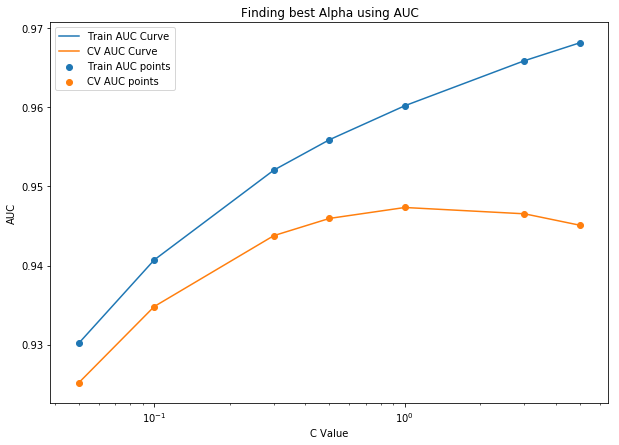

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
train_auc= []
cv_auc= []
c_value = [0.05,0.1,0.3,0.5,1,3,5]
for i in tqdm(c_value):
  model=LogisticRegression(C =i,random_state=4)
  model.fit(S1_train, y_train)
  y_train_pred=model.predict_proba(S1_train)[:,1]
  y_cv_pred=model.predict_proba(S1_CV)[:,1]
  train_auc.append(roc_auc_score(y_train,y_train_pred))
  cv_auc.append(roc_auc_score(y_CV, y_cv_pred))
plt.figure(figsize=(10,7))
plt.axes(xscale='log')
plt.plot(c_value, train_auc, label='Train AUC Curve')
plt.plot(c_value, cv_auc, label='CV AUC Curve')
plt.scatter(c_value, train_auc, label='Train AUC points')
plt.scatter(c_value, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("C Value")
plt.ylabel("AUC")
plt.title("Finding best Alpha using AUC")
plt.show()

### 8.4.2 Building best model


In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1, random_state=4)
model.fit(S1_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=4, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_train_pred = model.predict_proba(S1_train)[:,1]
y_cv_pred = model.predict_proba(S1_CV)[:,1]

### 8.4.3 ROC curve

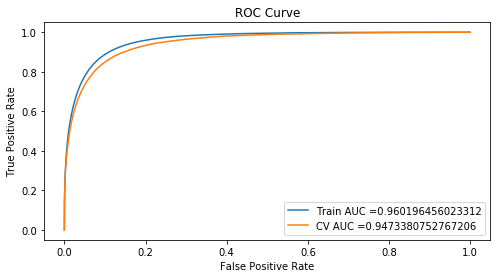

In [0]:
train_fpr,train_tpr,train_thresholds = roc_curve(y_train, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_CV,y_cv_pred)
train_auc =auc(train_fpr, train_tpr)
cv_auc = auc(cv_fpr, cv_tpr)
plt.figure(figsize=(8,4))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(cv_auc))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

### 8.4.4 Confusion Matrix

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("CV confusion matrix")
print(confusion_matrix(y_CV, predict_with_best_t(y_cv_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8015895797249579 for threshold 0.074
Train confusion matrix
[[1171823  156609]
 [  10540  104927]]
CV confusion matrix
[[292212  39896]
 [  3604  25263]]


**Train Confusion Matrix**

Text(0.5, -1.5, 'Predicted')

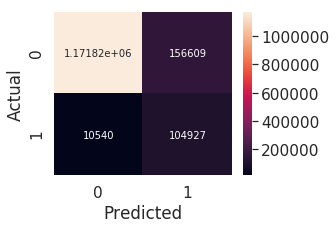

In [0]:
conf_matr_train = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), range(2),range(2))
conf_matr_cv = pd.DataFrame(confusion_matrix(y_CV, predict_with_best_t(y_cv_pred,best_t)), range(2),range(2))
plt.figure(figsize = (4,3))
sns.set(font_scale=1.4) #for label size
sns.heatmap(conf_matr_train, annot= True,annot_kws={"size": 10}, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

**Train Confusion Matrix**

Text(0.5, -1.5, 'Predicted')

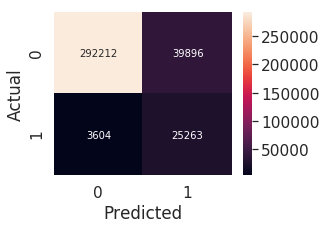

In [0]:
plt.figure(figsize = (4,3))
sns.set(font_scale=1.4) #for label size
sns.heatmap(conf_matr_cv, annot= True,annot_kws={"size": 10}, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## 8.5 Gradient Boosting (LGBM Classifier)


### 8.5.1 Hyperparameter tuning

In [0]:
from lightgbm import LGBMClassifier
hpms = {
'n_estimators':[10,20,50,70],
'max_depth':[2,5,7,9]
}
model = LGBMClassifier(n_jobs=-1)
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(model, hpms,cv=2,scoring='roc_auc',n_jobs=-1,verbose=1,return_train_score= True)
clf.fit(S1_train,y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 16.3min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7, 9],
                         'n_estima

### 8.5.2 Building best model

In [0]:
clf.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=9,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=70, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
model = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=9,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=70, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
model.fit(S1_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=9,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=70, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
y_train_pred = model.predict_proba(S1_train)[:,1]
y_cv_pred = model.predict_proba(S1_CV)[:,1]

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:478: UserWarning:

Converting data to scipy sparse matrix.



### 8.5.3 ROC curve

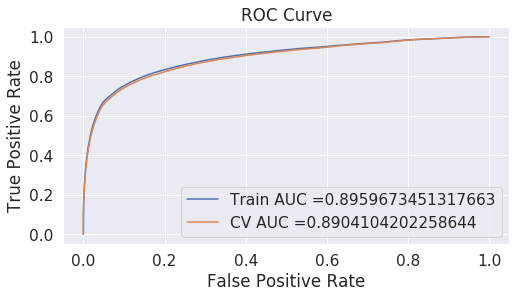

In [0]:
train_fpr,train_tpr,train_thresholds = roc_curve(y_train, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_CV,y_cv_pred)
train_auc =auc(train_fpr, train_tpr)
cv_auc = auc(cv_fpr, cv_tpr)
plt.figure(figsize=(8,4))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(cv_auc))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


### 8.5.4 Confusion Matrix

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("CV confusion matrix")
print(confusion_matrix(y_CV, predict_with_best_t(y_cv_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6815480228286783 for threshold 0.092
Train confusion matrix
[[1149187  179245]
 [  24496   90971]]
CV confusion matrix
[[286842  45266]
 [  6401  22466]]


**Train Confusion Matrix**

Text(0.5, -1.5, 'Predicted')

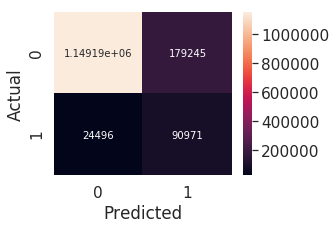

In [0]:
conf_matr_train = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), range(2),range(2))
conf_matr_cv = pd.DataFrame(confusion_matrix(y_CV, predict_with_best_t(y_cv_pred,best_t)), range(2),range(2))
plt.figure(figsize = (4,3))
sns.set(font_scale=1.4) #for label size
sns.heatmap(conf_matr_train, annot= True,annot_kws={"size": 10}, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

**CV Confusion Matrix**

Text(0.5, -1.5, 'Predicted')

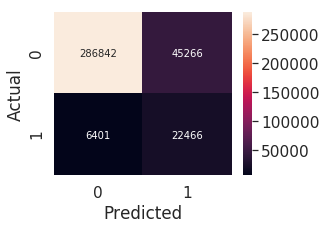

In [0]:
plt.figure(figsize = (4,3))
sns.set(font_scale=1.4) #for label size
sns.heatmap(conf_matr_cv, annot= True,annot_kws={"size": 10}, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# 9. Predicting on test data

In [0]:
model=SGDClassifier(class_weight='balanced',loss = 'log',alpha =0.000001)
model.fit(S1_train, y_train)

SGDClassifier(alpha=1e-06, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
predictions = model.predict_proba(S1_test)[:,1]

In [0]:
predictions.shape

(97320,)

In [0]:
submission = pd.read_csv('sample_submission.csv', index_col='id')


In [0]:
submission['prediction'] = predictions

In [0]:
submission.head(2)

,prediction
id,
7097320,0.223972
7097321,0.259976


In [0]:
submission.to_csv('submission.csv')


In [0]:
x.head(6)

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...
5,7097325,Let’s see if I understand this; Berkowitz anno...


In [0]:
results = x

In [0]:
results.to_csv('test_results.csv', index=False)

In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1, random_state=4)
model.fit(S1_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=4, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
predictions2 = model.predict_proba(S1_test)[:,1]

In [0]:
submission['prediction'] = predictions2

In [0]:
submission.head(2)

,prediction
id,
7097320,0.035973
7097321,0.045190


In [0]:
submission.to_csv('submission2.csv')

In [0]:
model=SGDClassifier(loss = 'hinge',alpha =0.000001)
model.fit(S1_train, y_train)

SGDClassifier(alpha=1e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
predictions3 = model.decision_function(S1_test)

In [0]:
submission = pd.read_csv('sample_submission.csv', index_col='id')

In [0]:
submission['prediction'] = predictions3

In [0]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
predictions_3_n = scalar.fit_transform(predictions3.reshape(-1,1))


In [0]:
predictions_3 = predictions_3_n.T

In [0]:
submission['prediction'] = predictions_3_n

In [0]:
predictions_3[0:10]

array([[0.16750955, 0.16821964, 0.16819804, ..., 0.25120245, 0.17611067,
        0.13685903]])

In [0]:
submission.head(2)

,prediction
id,
7097320,0.16751
7097321,0.16822


In [0]:
submission.to_csv('submission3.csv')

## LSTM

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/AAIC/Jigsaw

/content/drive/My Drive/AAIC/Jigsaw


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [0]:
from tqdm import tqdm
target = train['target']
label = []
for i in tqdm(target):
  if i < 0.5:
    temp = 0
  elif i>= 0.5:
    temp = 1
  label.append(temp)

100%|██████████| 1804874/1804874 [00:00<00:00, 1908942.03it/s]


In [0]:
label[0:10]

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]

In [0]:
train['target_label'] = label

In [0]:
train['target_label'].value_counts()

0    1660540
1     144334
Name: target_label, dtype: int64

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
# specific
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
# general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
from tqdm import tqdm
comment_text_pre_train = []
# tqdm is for printing the status bar
for sentance in tqdm(train['comment_text'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopwords)
    comment_text_pre_train.append(sent.lower().strip())

100%|██████████| 1804874/1804874 [03:30<00:00, 8567.12it/s]


In [0]:
from tqdm import tqdm
comment_text_pre_test = []
# tqdm is for printing the status bar
for sentance in tqdm(test['comment_text'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopwords)
    comment_text_pre_test.append(sent.lower().strip())

100%|██████████| 97320/97320 [00:11<00:00, 8778.00it/s]


In [0]:
comment_text_pre_train[0:10]

['cool like would want mother read really great idea well done',
 'thank would make life lot less anxiety inducing keep not let anyone get way',
 'urgent design problem kudos taking impressive',
 'something able install site releasing',
 'haha guys bunch losers',
 'ur sh tty comment',
 'hahahahahahahahhha suck',
 'ffffuuuuuuuuuuuuuuu',
 'ranchers seem motivated mostly greed no one right allow animals destroy public land',
 'great show not combo would expected good together']

In [0]:
train['comment_text_pre'] = comment_text_pre_train
test['comment_text_pre'] = comment_text_pre_test

In [0]:
train.drop(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'], axis=1, inplace= True)

In [0]:
label = train['target_label']
train.drop(['target_label'], axis=1, inplace= True)

In [0]:
train.columns

Index(['comment_text_pre'], dtype='object')

In [0]:
test.drop(['id','comment_text'], axis=1, inplace= True)

In [0]:
test.columns

Index(['comment_text_pre'], dtype='object')

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_CV, y_train, y_CV = train_test_split(train, label, test_size=0.20, random_state=0 , stratify = label)

In [0]:
print("Shape of X_train:",X_train.shape,"--- Shape of y_train:",y_train.shape)
print("Shape of X_CV:",X_CV.shape,"--- Shape of y_cv:",y_CV.shape)

Shape of X_train: (1443899, 1) --- Shape of y_train: (1443899,)
Shape of X_CV: (360975, 1) --- Shape of y_cv: (360975,)


In [0]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
docs =X_train['comment_text_pre']
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
print("Number of words tokenised",vocab_size)

Using TensorFlow backend.


Number of words tokenised 276182


In [0]:
t_text_train = t.texts_to_sequences(X_train['comment_text_pre'])
t_text_test = t.texts_to_sequences(test['comment_text_pre'])
t_text_cv = t.texts_to_sequences(X_CV['comment_text_pre'])

In [0]:
text_word_count= X_train['comment_text_pre'].apply(lambda row: len(row.split(" ")))

In [0]:
max(text_word_count)

221

In [0]:
from keras.preprocessing.sequence import pad_sequences
padded_t_text_train = pad_sequences(t_text_train, maxlen=225, padding='post')
padded_t_text_test = pad_sequences(t_text_test, maxlen=225, padding='post')
padded_t_text_cv = pad_sequences(t_text_cv, maxlen=225, padding='post')

In [0]:
padded_t_text_train.shape

(1443899, 225)

In [0]:
cd /content/drive/My Drive/AAIC

/content/drive/My Drive/AAIC


In [0]:
X_train = padded_t_text_train
X_test = padded_t_text_test
X_cv = padded_t_text_cv

In [0]:
X_train_new = np.expand_dims(X_train,2)
X_test_new = np.expand_dims(X_test,2)
X_CV_new = np.expand_dims(X_cv,2)

In [0]:
X_train_new.shape

(1443899, 225, 1)

In [0]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.42B.300d.txt','r',encoding="utf8")
for line in tqdm(f):
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

1917495it [03:18, 9677.16it/s] 

Loaded 1917495 word vectors.


In [0]:
#code credits : #https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
print('Total number of word vectors',len(embedding_matrix))

Total number of word vectors 276182


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Input
from keras.layers import Flatten

In [0]:
text_input = Input(shape=(225,), name='text_input')
embedding = Embedding(vocab_size, 300,weights=[embedding_matrix],trainable =False, input_length=225)(text_input)
x = LSTM(100,return_sequences= True)(embedding)
flatten = Flatten()(x)
output = Dense(2,activation='softmax', name='output')(flatten)

In [0]:
from keras.models import Model
model1 = Model(inputs = [text_input],outputs=[output])

In [0]:
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      (None, 225)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 225, 300)          82854600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 225, 100)          160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 22500)             0         
_________________________________________________________________
output (Dense)               (None, 2)                 45002     
Total params: 83,060,002
Trainable params: 205,402
Non-trainable params: 82,854,600
_________________________________________________________________


In [0]:
from sklearn.metrics import roc_auc_score
import tensorflow as tf
def aucc(y_true, y_pred):
  if len(np.unique(y_true[:,1])) == 1:
    return 0.5
  else:
    return roc_auc_score(y_true, y_pred)
def auroc(y_true, y_pred):
  return tf.py_func(aucc, (y_true, y_pred), tf.double)

In [0]:
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2)
Y_cv = np_utils.to_categorical(y_CV, 2)

In [0]:
from time import time
from keras.callbacks import TensorBoard
tensorboard1=TensorBoard(log_dir='./model-jig-1'.format(time()), write_graph= True, write_images= True)

In [0]:
cd /content/drive/My Drive/AAIC

/content/drive/My Drive/AAIC


In [0]:
from keras.models import load_model
dependencies = {
    'auroc': auroc
}

model1 = load_model('model1-jig-lstm-e3.h5',custom_objects=dependencies)



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])

In [0]:
inspect = model1.fit(X_train,Y_train, epochs=1,verbose=1,callbacks=[tensorboard1],validation_data=(X_cv, Y_cv))

Train on 1443899 samples, validate on 360975 samples


Epoch 1/1
1443899/1443899 [==============================] - 21246s 15ms/step - loss: 0.1131 - auroc: 0.9345 - val_loss: 0.1381 - val_auroc: 0.9144



In [0]:
model1.save("model1-jig-lstm-e4.h5")

In [0]:
cd/content/drive/My Drive/AAIC

/content/drive/My Drive/AAIC


In [0]:
from keras.models import load_model
dependencies = {
    'auroc': auroc
}

model1 = load_model('model1-jig-lstm-e4.h5',custom_objects=dependencies)



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])

In [0]:
inspect = model1.fit(X_train,Y_train, epochs=1,verbose=1,callbacks=[tensorboard1],validation_data=(X_cv, Y_cv))

Train on 1443899 samples, validate on 360975 samples


Epoch 1/1
1443899/1443899 [==============================] - 23466s 16ms/step - loss: 0.1074 - auroc: 0.9383 - val_loss: 0.1448 - val_auroc: 0.9113



In [0]:
model1.save("model1-jig-lstm-e5.h5")

In [0]:
cd /content/drive/My Drive/AAIC

/content/drive/My Drive/AAIC


In [0]:
from keras.models import load_model
dependencies = {
    'auroc': auroc
}

model1 = load_model('model1-jig-lstm-e5.h5',custom_objects=dependencies)



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])

In [0]:
inspect = model1.fit(X_train,Y_train, epochs=1,verbose=1,callbacks=[tensorboard1],validation_data=(X_cv, Y_cv))

Train on 1443899 samples, validate on 360975 samples


Epoch 1/1
1443899/1443899 [==============================] - 21137s 15ms/step - loss: 0.1021 - auroc: 0.9406 - val_loss: 0.1506 - val_auroc: 0.9094



In [0]:
model1.save("model1-jig-lstm-e6.h5")

#Predicting Test results (LSTM)

In [0]:
from keras.models import load_model
dependencies = {
    'auroc': auroc
}

model2 = load_model('model1-jig-lstm-e1.h5',custom_objects=dependencies)



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      (None, 225)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 225, 300)          82854600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 225, 100)          160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 45002     
Total params: 83,060,002
Trainable params: 205,402
Non-trainable params: 82,854,600
_________________________________________________________________


In [0]:
predictions_lstm_1 = model2.predict(X_test)[:, 1]

In [0]:
predictions_lstm_1[0:10]

array([4.0937406e-03, 5.6941994e-03, 1.8891196e-01, 5.1085497e-03,
       4.7962379e-04, 1.5886521e-06, 9.7741812e-01, 4.2528260e-01,
       2.3483299e-03, 3.3111635e-03], dtype=float32)

In [0]:
cd /content/drive/My Drive/AAIC/Jigsaw

/content/drive/My Drive/AAIC/Jigsaw


In [0]:
submission_lstm_e1 = pd.read_csv('sample_submission.csv', index_col='id')

In [0]:
submission_lstm_e1['prediction'] = predictions_lstm_1

In [0]:
submission_lstm_e1.head(3)

,prediction
id,
7097320,0.004094
7097321,0.005694
7097322,0.188912


In [0]:
submission_lstm_e1.to_csv('submission_lstm_e1.csv')

In [0]:
cd /content/drive/My Drive/AAIC

/content/drive/My Drive/AAIC


In [0]:
from keras.models import load_model
dependencies = {
    'auroc': auroc
}

model3 = load_model('model1-jig-lstm-e2.h5',custom_objects=dependencies)

In [0]:
model3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      (None, 225)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 225, 300)          82854600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 225, 100)          160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 45002     
Total params: 83,060,002
Trainable params: 205,402
Non-trainable params: 82,854,600
_________________________________________________________________


In [0]:
predictions_lstm_2 = model3.predict(X_test)[:, 1]

In [0]:
predictions_lstm_2[0:10]

array([1.7607168e-03, 7.1490277e-03, 8.4803768e-02, 2.2654061e-03,
       6.1862258e-05, 2.8292405e-05, 9.6907872e-01, 4.3919659e-01,
       1.4948067e-03, 1.1656043e-03], dtype=float32)

In [0]:
cd /content/drive/My Drive/AAIC/Jigsaw

/content/drive/My Drive/AAIC/Jigsaw


In [0]:
submission_lstm_e2 = pd.read_csv('sample_submission.csv', index_col='id')

In [0]:
submission_lstm_e2['prediction'] = predictions_lstm_2

In [0]:
submission_lstm_e2.head(3)

,prediction
id,
7097320,0.001761
7097321,0.007149
7097322,0.084804


In [0]:
submission_lstm_e2.to_csv('submission_lstm_e2.csv')

In [0]:
cd /content/drive/My Drive/AAIC

/content/drive/My Drive/AAIC


In [0]:
from keras.models import load_model
dependencies = {
    'auroc': auroc
}

model4 = load_model('model1-jig-lstm-e3.h5',custom_objects=dependencies)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
model4.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      (None, 225)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 225, 300)          82854600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 225, 100)          160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 45002     
Total params: 83,060,002
Trainable params: 205,402
Non-trainable params: 82,854,600
_________________________________________________________________


In [0]:
predictions_lstm_3 = model4.predict(X_test)[:, 1]

In [0]:
predictions_lstm_3[0:10]

array([2.9623293e-04, 5.3849327e-03, 3.9187100e-02, 6.3957373e-04,
       6.5934088e-05, 2.7725064e-05, 9.6867812e-01, 3.5331985e-01,
       3.5133559e-04, 2.4533487e-04], dtype=float32)

In [0]:
cd /content/drive/My Drive/AAIC/Jigsaw

/content/drive/My Drive/AAIC/Jigsaw


In [0]:
submission_lstm_e3 = pd.read_csv('sample_submission.csv', index_col='id')

In [0]:
submission_lstm_e3['prediction'] = predictions_lstm_3

In [0]:
submission_lstm_e3.head(3)

,prediction
id,
7097320,0.000296
7097321,0.005385
7097322,0.039187


In [0]:
submission_lstm_e3.to_csv('submission_lstm_e3.csv')

In [0]:
cd /content/drive/My Drive/AAIC

/content/drive/My Drive/AAIC


In [0]:
from keras.models import load_model
dependencies = {
    'auroc': auroc
}

model1 = load_model('model1-jig-lstm-e4.h5',custom_objects=dependencies)



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      (None, 225)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 225, 300)          82854600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 225, 100)          160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 45002     
Total params: 83,060,002
Trainable params: 205,402
Non-trainable params: 82,854,600
_________________________________________________________________


In [0]:
predictions_lstm_4 = model1.predict(X_test)[:, 1]

In [0]:
predictions_lstm_4[0:10]

array([1.0141762e-03, 8.0274027e-03, 6.2677450e-02, 2.1175608e-04,
       1.5880707e-04, 3.8830254e-05, 8.9369535e-01, 1.3135289e-01,
       1.8770376e-03, 1.0296651e-03], dtype=float32)

In [0]:
cd /content/drive/My Drive/AAIC/Jigsaw

/content/drive/My Drive/AAIC/Jigsaw


In [0]:
submission_lstm_e4 = pd.read_csv('sample_submission.csv', index_col='id')

In [0]:
submission_lstm_e4['prediction'] = predictions_lstm_4

In [0]:
submission_lstm_e4.head(3)

,prediction
id,
7097320,0.001014
7097321,0.008027
7097322,0.062677


In [0]:
submission_lstm_e4.to_csv('submission_lstm_e4.csv')

In [0]:
cd /content/drive/My Drive/AAIC

/content/drive/My Drive/AAIC


In [0]:
from keras.models import load_model
dependencies = {
    'auroc': auroc
}

model1 = load_model('model1-jig-lstm-e5.h5',custom_objects=dependencies)

In [0]:
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      (None, 225)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 225, 300)          82854600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 225, 100)          160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 45002     
Total params: 83,060,002
Trainable params: 205,402
Non-trainable params: 82,854,600
_________________________________________________________________


In [0]:
predictions_lstm_5 = model1.predict(X_test)[:, 1]

In [0]:
predictions_lstm_5[0:10]

array([1.8305619e-03, 7.1205860e-03, 6.9413878e-02, 2.0013826e-03,
       1.7885477e-04, 5.2077444e-06, 9.6780539e-01, 1.3070931e-01,
       1.7064234e-03, 1.7947126e-03], dtype=float32)

In [0]:
cd /content/drive/My Drive/AAIC/Jigsaw

/content/drive/My Drive/AAIC/Jigsaw


In [0]:
submission_lstm_e5 = pd.read_csv('sample_submission.csv', index_col='id')

In [0]:
submission_lstm_e5['prediction'] = predictions_lstm_5

In [0]:
submission_lstm_e5.head(3)

,prediction
id,
7097320,0.001831
7097321,0.007121
7097322,0.069414


In [0]:
submission_lstm_e5.to_csv('submission_lstm_e5.csv')

In [0]:
cd /content/drive/My Drive/AAIC

/content/drive/My Drive/AAIC


In [0]:
from keras.models import load_model
dependencies = {
    'auroc': auroc
}

model1 = load_model('model1-jig-lstm-e6.h5',custom_objects=dependencies)

In [0]:
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      (None, 225)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 225, 300)          82854600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 225, 100)          160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 45002     
Total params: 83,060,002
Trainable params: 205,402
Non-trainable params: 82,854,600
_________________________________________________________________


In [0]:
predictions_lstm_6 = model1.predict(X_test)[:, 1]

In [0]:
predictions_lstm_6[0:10]

array([7.6843979e-04, 3.2239028e-03, 4.8474792e-02, 1.6333268e-05,
       3.3556767e-05, 6.1910764e-06, 9.6082616e-01, 2.4334987e-01,
       5.1126550e-03, 1.1350180e-03], dtype=float32)

In [0]:
cd /content/drive/My Drive/AAIC/Jigsaw

/content/drive/My Drive/AAIC/Jigsaw


In [0]:
submission_lstm_e6 = pd.read_csv('sample_submission.csv', index_col='id')

In [0]:
submission_lstm_e6['prediction'] = predictions_lstm_6

In [0]:
submission_lstm_e6.head(3)

,prediction
id,
7097320,0.000768
7097321,0.003224
7097322,0.048475


In [0]:
submission_lstm_e6.to_csv('submission_lstm_e6.csv')

# 10.Conclusions

In [0]:
from prettytable import PrettyTable
model = ['Naive Bayes','Linear SVM(SGD)', 'Logistic Regression (SGD and Class weight balanced)', 'Logistic Regression (No Class weight)','Gradient Boosting (LGBM)','LSTM(Epochs -3)']
hpms = ['Alpha = 0.1','Alpha = 0.000001','Alpha = 0.000001','C=1','n_estimators = 70,max_depth = 9','Lstm units = 100']
Train_auc = [0.915,0.959,0.9657,0.9601,0.895,0.92]
cv_auc = [0.879,0.939,0.9486,0.9473,0.8904,0.919]
final_score = ['---',0.8951,0.8966,0.8947,'---',0.9076]
sno =[1,2,3,4,5,6]
table = PrettyTable()
table.add_column("S.NO.",sno)
table.add_column("Model",model)
table.add_column("Best Hyperparameters",hpms)
table.add_column("Training AUC",Train_auc)
table.add_column("CV AUC",cv_auc)
table.add_column("Final Score",final_score)

In [2]:
print('Comparison of all the models')
print('*'*30)
print(table)

Comparison of all the models
******************************
+-------+-----------------------------------------------------+---------------------------------+--------------+--------+-------------+
| S.NO. |                        Model                        |       Best Hyperparameters      | Training AUC | CV AUC | Final Score |
+-------+-----------------------------------------------------+---------------------------------+--------------+--------+-------------+
|   1   |                     Naive Bayes                     |           Alpha = 0.1           |    0.915     | 0.879  |     ---     |
|   2   |                   Linear SVM(SGD)                   |         Alpha = 0.000001        |    0.959     | 0.939  |    0.8951   |
|   3   | Logistic Regression (SGD and Class weight balanced) |         Alpha = 0.000001        |    0.9657    | 0.9486 |    0.8966   |
|   4   |        Logistic Regression (No Class weight)        |               C=1               |    0.9601    | 0.9473 |   

**1. Jigsaw is a technology incubator which was child comapny of google. It mainly focuses on providing remedies to Internet attacks , online attacks on free speech etc;**

**2. The task given was to reduce the unintended bias towards certain religion groups ,communities ,genders during toxicity classification of comments on them.**

**3. The AUC was given as metric to be used.**

**4. The dataset provided was huge with around 1.8 Million data points and 45 features. Among those features , identity features were present and in almost all the cases they were Null values. Also , a test set was also provided with 2 features namely, comment text and Target.**

**5. One of the features  'comment_text' represents the text comment and another one was target which determines the toxicity of the comment.So, the problem was to measure the toxicity of the comment by analysing the text.**

**6. This problem can be posed as a classification problem by classifying the comments as toxic and non-toxic . So ,the comments which are over 0.5 toxicity were taken as toxic comments and rest of them were taken as Non-toxic and were also labeled accordingly.**

**7. The train dataset was highly imbalanced with 92% non toxic comments and 8% toxic comments. So a dumb model can achieve 92 % accuracy by predicting all of them as non-toxic .**

**8.Initially , new features such as comment length , number of words in the comment were constructed . After this , text preprocessing was done by removing unnecessary punctuations , stopwards etc;**


**9. In addition to those 2 features , another four features namely Compound ,Positive ,Negative , Neutral were created by using NLTK's Vadar Sentiment Intensity Analyser.**


**10. These four features were stacked to the train and test datasets and some analysis was done on these features.**

**11. Then the Train dataset was divided into Train and cv datasets. The text of all the datasets was vectorised using Tfidf Vectoriser.**

**12. Several ML models such as Naive Bayes, Logistic Regression , Linear SVM , Gradient Boosting had their hyperparameters tuned and were trained on their best hyperparameters.**


**13. Among all the models SGD classifier (Logistic regression with balanced class weight) performed better with 96.5 train AUC and 94.8 CV AUC.**

**14. An LSTM model was trained for 6 epochs and the predictions were made on test data after each epoch.**

**15. At last predictions were made on test dataset with the best model (Logistic regression with class weight balanced)**

**16. All the predicitions were submitted on kaggle and the results are shown in comparison table for each model.**
